In [25]:
from general import *

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/motion_primitive_neuron')

Folder 'images' already exists.
Folder 'images/motion_primitive_neuron' already exists.


In [26]:
class MotionPrimitiveNeuron():
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(MotionPrimitiveNeuron, self).__init__()
        self.tau = parameters['tau']
        self.V_R = parameters['V_R']
        self.V_T = parameters['V_T']
        self.w = parameters['w']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.V_R),
                                          w=np.array(self.w),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
            
        V = self.state.V
        w = self.state.w
        I = self.state.I
        

        V += self.dt*(self.V_R-V)/self.tau
        V += np.sum(w*input, axis=-1)

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [27]:
def get_encoding(w_pos=[0, 0, 0, 0, 0, 0, 0], w_vel=[0, 0, 0, 0, 0, 0, 0], n=6):
    encoding = ['none', 'Vel-', 'Vel+', 'Pos-', 'Pos+']
    perm = np.array(list(product(encoding, repeat=3)))
    base_perm = np.array(list(product([-np.inf, 0, 1, 2, 3], repeat=3)))

    synapse_type = []

    for permutation in perm:

        if 'none' in permutation:
            synapse_type.append(0 if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 2
                                else
                                (1 if (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 2
                                 else
                                 (2 if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 1
                                       and (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 1
                                  else -1)))
        else:
            synapse_type.append(3 if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 2
                                else
                                (4 if (permutation == 'Vel+').sum() + (permutation == 'Vel-').sum() == 2
                                 else
                                 (5 if (permutation == 'Pos+').sum() + (permutation == 'Pos-').sum() == 3
                                  else 6)))

    zero_index = np.where(np.array(synapse_type) == -1)[0]

    synapse_type = list(np.delete(synapse_type, zero_index))
    perm = np.delete(perm, zero_index, axis=0)
    base_perm = np.delete(base_perm, zero_index, axis=0)
    weights = np.zeros_like(perm, dtype=float)

    for i, j in np.ndindex(weights.shape):
        if 'Pos' in perm[i, j]:
            weights[i, j] = w_pos[synapse_type[i]]
        elif 'Vel' in perm[i, j]:
            weights[i, j] = w_vel[synapse_type[i]]

    negative_mask = np.zeros_like(perm, dtype=float)
    negative_mask[perm == 'none'] = 1
    negative_mask = np.tile(negative_mask, (6, 1))
    positive_mask = 1 - negative_mask

    weights = np.tile(weights, (6, 1))
    synapse_type = synapse_type * 6

    extra = np.array([0, 4, 8])
    extra = np.tile(extra, (base_perm.shape[0], 1))
    final_perm = (base_perm + extra).clip(min=0)

    extra_2 = np.linspace(0, 12 * (n - 1), num=n).repeat(3 * final_perm.shape[0])
    final_perm = (np.tile(final_perm.flatten(), n) + extra_2).astype(int)

    base_perm = base_perm + 1
    base_perm[base_perm == -np.inf] = 0

    return perm, base_perm.astype(int), final_perm, synapse_type, weights, positive_mask, negative_mask


def prepare_spikes_primitive(spike_velocity, spike_position, permutations, mask):
    toepel = ()
    for i in range(18):
        toepel += (spike_velocity[[0 + 2 * i, 1 + 2 * i]], spike_position[[0 + 2 * i, 1 + 2 * i]])

    pos_vel_spikes = np.concatenate(toepel)
    pos_vel_spikes = pos_vel_spikes[permutations].reshape(mask.shape) * mask

    return pos_vel_spikes


def convert_to_bins(old_array, n_bins, minimum=0, sum_bool=False):
    old_array = np.transpose(old_array)

    while old_array.shape[1] != n_bins:
        try:
            old_array = np.sum(old_array.reshape(old_array.shape[0], n_bins, -1), axis=2)
        except:
            old_array = np.column_stack((old_array, old_array[:, -1]))

    if not sum_bool:
        old_array = (old_array > minimum).astype(int)

    return np.transpose(old_array)

In [28]:
with open('data/joint_angles_' + parameters['joint_string'], 'rb') as file:
    joint_angles = np.load(file)
    
with open('data/spike_position', 'rb') as file:
    spike_position = np.load(file) 
    
with open('data/spike_motion', 'rb') as file:
    spike_motion = np.load(file) 

In [29]:

N_BINS = 100

permutations_string, permutations_base, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding([0]*7, [0]*7)

ground_truth = np.empty((constants['N_STEPS'], len(synapse_type), parameters['N_SIMULATIONS']))
ground_truth_bins = np.zeros((N_BINS, len(synapse_type), parameters['N_SIMULATIONS']))
true_positive, false_positive, true_negative, false_negative = [np.zeros((len(synapse_type), parameters['N_SIMULATIONS'])) for _ in range(4)]
true_positive_groups, false_positive_groups, true_negative_groups, false_negative_groups = [np.zeros(7) for _ in range(4)]

In [30]:
for k in range(parameters['N_SIMULATIONS']): 
    ground_mot, ground_pos = np.zeros((constants['N_STEPS'], 36)), np.zeros((constants['N_STEPS'], 36))
    for i in range(constants['N_ANGLES']):
        mid = np.max(joint_angles[:, i, k]) / 2 + np.min(joint_angles[:, i, k]) / 2
        diff = np.diff(joint_angles[:, i, k]) / constants['dt']

        ground_mot[np.where(diff < 0), 0 + 2 * i] = 1
        ground_mot[np.where(diff > 0), 1 + 2 * i] = 1
        ground_pos[np.where(joint_angles[:, i, k] < mid), 0 + 2 * i] = 1
        ground_pos[np.where(joint_angles[:, i, k] > mid), 1 + 2 * i] = 1
        
    for j in range(constants['N_STEPS']):
        ground_truth_j = prepare_spikes_primitive(ground_mot[j, :], ground_pos[j, :], permutations_final, mask_positive) + mask_negative
        ground_truth_j = np.sum(ground_truth_j, axis=1)
        
        ground_truth[j, ground_truth_j > 2.9, k] = 1
        ground_truth[j, ground_truth_j < 2.9, k] = 0

    ground_truth_bins[:, :, k] = convert_to_bins(ground_truth[:, :, k], N_BINS)

In [31]:
N_WEIGHTS = 1
N_TAU = 11

tau_list = np.linspace(0e-3, 1e-3, num=N_TAU)
w_pos_list = np.linspace(10e-3, 20e-3, num=N_WEIGHTS)
w_vel_list = np.linspace(10e-3, 20e-3, num=N_WEIGHTS)

spike_primitive = np.empty((constants['N_STEPS'], len(synapse_type)), dtype=np.uint8)
mcc_list = np.zeros((7, N_TAU, N_WEIGHTS, N_WEIGHTS))

for p, l, m  in tqdm(np.ndindex(N_TAU, N_WEIGHTS, N_WEIGHTS), desc=f'Total iterations: {N_TAU*N_WEIGHTS*N_WEIGHTS}'):
    
    w_pos = [w_pos_list[l]] * 7
    w_vel = [w_vel_list[m]] * 7
    
    permutations_string, permutations_base, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding(w_pos, w_vel)
    
    primitive_parameters = {'tau': tau_list[p], 'V_T': -50e-3, 'V_R': -70e-3, 'n': len(synapse_type), 'w': weights_primitive, 'N_input': 3, 'dt': constants['dt']}
    
    primitive_neuron = MotionPrimitiveNeuron(primitive_parameters)
    primitive_neuron.initialize_state()
    
    for k in range(parameters['N_SIMULATIONS']):        
        for i in range(constants['N_STEPS']):
            pos_vel_spikes = prepare_spikes_primitive(spike_motion[i, :, k], spike_position[i, :, k], permutations_final, mask_positive)
            _, spike_primitive[i, :] = primitive_neuron.forward(pos_vel_spikes) 
 
        spike_primitive_bins = convert_to_bins(spike_primitive, N_BINS)
        
        for i in range(primitive_parameters['n']):
            true_positive[i, k], false_positive[i, k], true_negative[i, k], false_negative[i, k] = (
                get_confusion_matrix(spike_primitive_bins[:, i], ground_truth_bins[:, i, k]))
    
    for i in range(7):
        indices = np.where(np.array(synapse_type) == i)
        
        true_positive_groups[i] = np.sum(true_positive[indices, :])
        true_negative_groups[i] = np.sum(true_negative[indices, :])
        false_positive_groups[i] = np.sum(false_positive[indices, :])
        false_negative_groups[i] = np.sum(false_negative[indices, :])
                
        mcc = matthews_correlation(true_positive_groups[i], true_negative_groups[i], false_positive_groups[i], false_negative_groups[i])
            
        mcc_list[i, p, l, m] = mcc

Total iterations: 11: 0it [00:00, ?it/s]

C:\Users\thoma\AppData\Local\Temp/ipykernel_26772/4028894417.py:30: RuntimeWarning: invalid value encountered in true_divide
  V += self.dt*(self.V_R-V)/self.tau


0.0 10026.0 0.0 4374.0
0
0.0 8135.0 0.0 6265.0
0
0.0 18239.0 0.0 10561.0
0
0.0 23119.0 0.0 5681.0
0
0.0 22124.0 0.0 6676.0
0
0.0 8013.0 0.0 1587.0
0
0.0 7024.0 0.0 2576.0
0
4371.0 3184.0 6842.0 3.0
0.3510408741704543
6065.0 2442.0 5693.0 200.0
0.343608365241398
10517.0 5690.0 12549.0 44.0
0.37145850695224664
5681.0 2720.0 20399.0 0.0
0.16008790846463677
6672.0 2502.0 19622.0 4.0
0.1684176992203016
1587.0 1010.0 7003.0 0.0
0.1526001628142842
2548.0 753.0 6271.0 28.0
0.15613884810584502
3122.0 10026.0 0.0 1252.0
0.796571685262298
1452.0 8004.0 131.0 4813.0
0.3418033331291427
4847.0 18105.0 134.0 5714.0
0.5754300865248572
4931.0 16584.0 6535.0 750.0
0.47580583346377914
4761.0 17281.0 4843.0 1915.0
0.442389057051201
1514.0 5236.0 2777.0 73.0
0.45384064660107765
1207.0 5902.0 1122.0 1369.0
0.3192168243448276
3464.0 10026.0 0.0 910.0
0.8520874163490222
2009.0 7975.0 160.0 4256.0
0.4172038978231655
5988.0 18061.0 178.0 4573.0
0.6546467562759474
5299.0 15278.0 7841.0 382.0
0.474239019285409
54

In [32]:
w_1_opt, w_2_opt, accuracy_opt = np.zeros([N_TAU, 7]), np.zeros([N_TAU, 7]), np.zeros([N_TAU, 7])

for i in range(N_TAU):
    for j in range(7):
        max_indices = np.where(mcc_list[j, i, :, :] == np.max(mcc_list[j, i, :, :]))

        w_1_opt[i, j], w_2_opt[i, j] = w_pos_list[max_indices[0][0]], w_vel_list[max_indices[1][0]]

        accuracy_opt[i, j] = mcc_list[j, i, max_indices[0][0], max_indices[1][0]]   

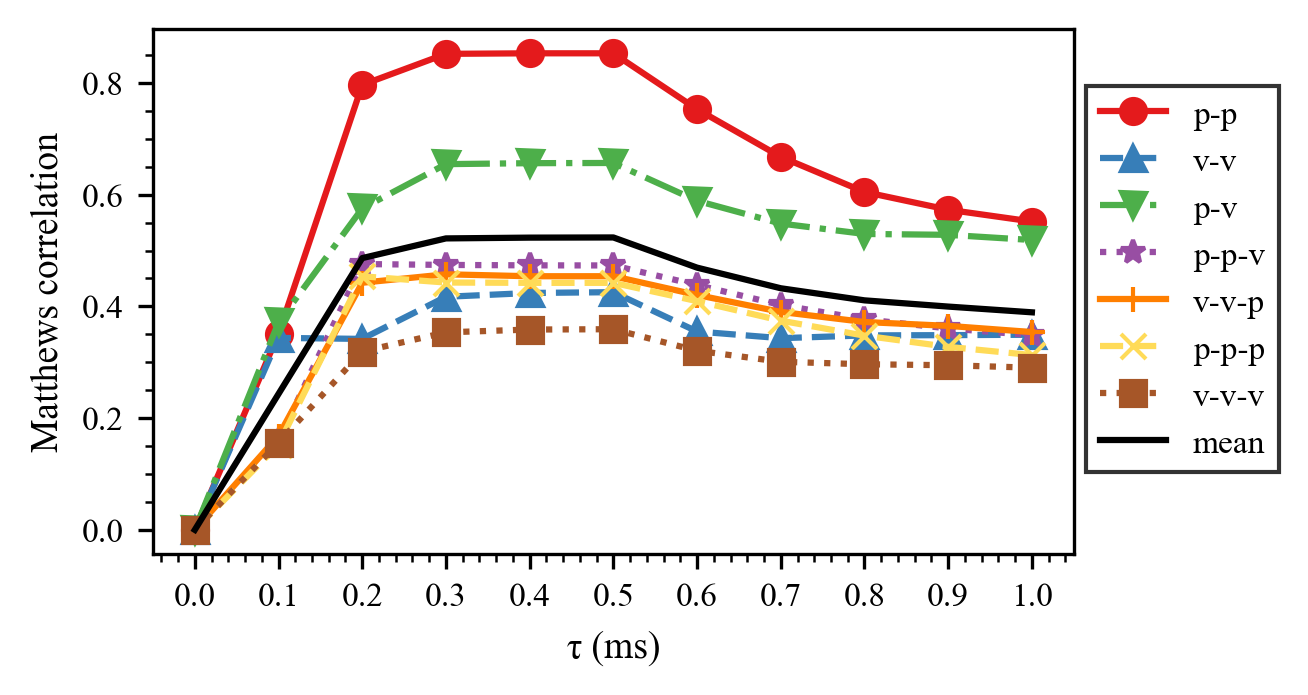

In [33]:
fig, ax = plt.subplots()

for i in range(7):
    ax.plot(tau_list * 1000, accuracy_opt[:, i], color=custom_colors[i], linestyle=custom_linestyles[i], marker=custom_markers[i])
ax.plot(tau_list * 1000, np.mean(accuracy_opt, axis=1), color='black')

ax.minorticks_on()
ax.set_xlabel('τ (ms)')
ax.set_ylabel("Matthews correlation")
ax.set_xticks(1000 * tau_list)
fig.legend(['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v', 'mean'], loc='upper center',
           bbox_to_anchor=(1.09, 0.92), fancybox=False, edgecolor='black')
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_primitive_neuron/primitive_accuracy.png', bbox_inches='tight')
fig.savefig('images/motion_primitive_neuron/primitive_accuracy.pdf', bbox_inches='tight')

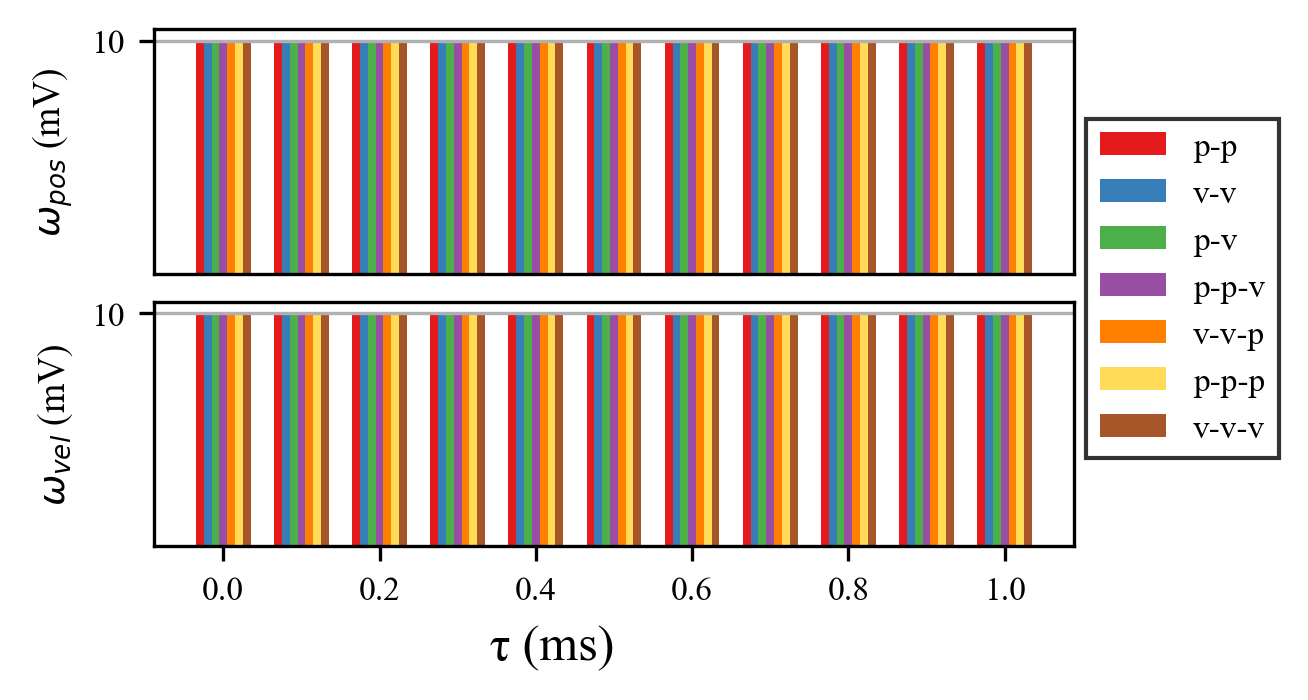

In [34]:
fig, ax = plt.subplots(2)

width = 100 * (tau_list[1] - tau_list[0])
for i in range(tau_list.size):
    for j in range(7):
        ax[0].bar(tau_list[i] * 1000 + (-3 * width + width * j), w_1_opt[i, j] * 1000, width, color=custom_colors[j])
        ax[1].bar(tau_list[i] * 1000 + (-3 * width + width * j), w_2_opt[i, j] * 1000, width, color=custom_colors[j])
        
        
ax[0].grid(True, axis='y')
ax[1].grid(True, axis='y')
ax[0].set_xticks([])
ax[0].set_yticks(1000 * w_pos_list[::2])
ax[1].set_yticks(1000 * w_vel_list[::2])
ax[0].set_ylabel(r'$\omega_{pos}$ (mV)')
ax[1].set_ylabel(r'$\omega_{vel}$ (mV)')
fig.legend(['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v'], loc='upper center', bbox_to_anchor=(1.09, 0.87), fancybox=False, edgecolor='black')
fig.supxlabel('τ (ms)')
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_primitive_neuron/primitive_weights.png', bbox_inches='tight')
fig.savefig('images/motion_primitive_neuron/primitive_weights.pdf', bbox_inches='tight')

In [35]:
mcc_list_max = np.max(mcc_list, axis=(1, 2, 3))
average_mcc_max = np.average(mcc_list_max, weights=np.bincount(synapse_type), axis=0)

table = {'MCC': np.append(np.around(mcc_list_max, 3), np.around(average_mcc_max, 3))}
df = pd.DataFrame(data=table, index=['p-p', 'v-v', 'p-v', 'p-p-v', 'v-v-p', 'p-p-p', 'v-v-v', 'mean'])
df.to_csv('results/primitive_accuracy_table.csv')

In [36]:
W_POS = [11e-3, 0, 16.5e-3, 15e-3, 16.5e-3, 9e-3, 0e-3]
W_VEL = [0e-3, 10.5e-3, 12e-3, 3e-3, 7.5e-3, 0e-3, 10e-3]

permutations_string, permutations_base, permutations_final, synapse_type, weights_primitive, mask_positive, mask_negative = get_encoding(W_POS, W_VEL)

time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

primitive_parameters = {'tau': .5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': len(synapse_type), 'w': weights_primitive, 'N_input': 3, 'dt': constants['dt']}

primitive_neuron = MotionPrimitiveNeuron(primitive_parameters)
primitive_neuron.initialize_state()

spike_primitive = np.empty((constants['N_STEPS'], primitive_parameters['n'], parameters['N_SIMULATIONS']))

for k in range(parameters['N_SIMULATIONS']):        
    for i in range(constants['N_STEPS']):
        pos_vel_spikes = prepare_spikes_primitive(spike_motion[i, :, k], spike_position[i, :, k], permutations_final, mask_positive)
        _, spike_primitive[i, :, k] = primitive_neuron.forward(pos_vel_spikes)
        
with open('data/spike_primitive', 'wb') as file:
        np.save(spike_primitive, file)